In [1]:
import tables as tb
import pandas as pd
omadatalocation = '/data/databases/OMA/OMA.2.1.1/data/OmaServer.h5'



In [2]:
omadata = tb.open_file(omadatalocation)

In [3]:
print(omadata.root.HogLevel.description)

Description([('Fam', '()i4'), ('ID', '()S255'), ('Level', '()S255')])


/usr/local/lib/python2.7/dist-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/_i_HogLevel/ID/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [4]:
print(omadata.root.HogLevel[0:10])

[(299330, 'HOG:0299330', 'Chromadorea')
 (299330, 'HOG:0299330', 'Pristionchus pacificus')
 (299330, 'HOG:0299330', 'Onchocercidae')
 (299330, 'HOG:0299330', 'Brugia malayi')
 (299330, 'HOG:0299330', 'Loa loa')
 (299330, 'HOG:0299330', 'Onchocerca volvulus')
 (299330, 'HOG:0299330', 'Rhabditida')
 (299330, 'HOG:0299330', 'Strongyloides ratti')
 (299330, 'HOG:0299330', 'Caenorhabditis')
 (299330, 'HOG:0299330', 'Caenorhabditis brenneri')]


<h1> Using sets to count the unique occurences in each column</h1>

In [5]:
Taxa = set([])
Hogs = set([])
Fams = set([])
rows = 0

for row in omadata.root.HogLevel:
    Taxa.add(row[2])
    Hogs.add(row[1])
    Fams.add(row[0])
    rows+=1

print(len(Taxa))
print('taxa')
print(len(Hogs))
print('Hogs')
print(len(Fams))
print('Fams')
print(rows)
print('entries')
    

2920
taxa
2715332
Hogs
589223
Fams
17467463
entries


In [6]:
import pickle
    
handle1 = open('./hogs.pkl','w')
handle2= open('./fams.pkl','w')
handle3 = open('./taxa.pkl','w')

pickle.dump(Hogs,handle1,-1)
pickle.dump(Fams,handle2,-1)
pickle.dump(Taxa,handle3,-1)

handle1.close()
handle2.close()
handle3.close()

<h1> Create a dictionary for HOGs and families </h1> The taxonomy dict isn't really necesary since we have one from the other taxonomy notebook that will be more useful in selecting our reference taxa later.

In [5]:
#use the column dictionary from the taxonomic analysis here
import pickle
import numpy as np
handle1 = open('./column_dict.pkl', 'r')
handle2= open('./NameToID.pkl','r')

NameToID = pickle.load(handle2, )
column_dict = pickle.load(handle1)
handle1.close()
handle2.close()


handle1 = open('./hogs.pkl','r')
handle2= open('./fams.pkl','r')
handle3 = open('./taxa.pkl','r')

Hogs = pickle.load(handle1)
Fams = pickle.load(handle2)
Taxa = pickle.load(handle3)

handle1.close()
handle2.close()
handle3.close()


coldict={}
coldictReverse = {}
for i,taxon in enumerate(Taxa):
    coldict[taxon]=i
    coldictReverse[i] = taxon
rowdict={}
rowdictReverse={}
#define a row for each unique hog
for i,hog in enumerate(Hogs):
    rowdict[hog]= i
    rowdictReverse[i]=hog
rowdictFam ={}
rowdictFamReverse = {}
#define a row for each unique family
#dont know if we'll use this...
for i,fam in enumerate(Fams):
    rowdictFam[fam] = i
    rowdictFamReverse[i]=fam



colmax=max(column_dict.values())+1
rowmax=len(Hogs)+1

from scipy.sparse import lil_matrix

def retMatrixChunk( Hogdatachunk ):
    matrix = lil_matrix((rowmax,colmax))
    fams,hogs,taxa =Hogdatachunk
    matrix[ ([rowdict[hog] for hog in hogs] , [column_dict[NameToID [taxon]] for taxon in taxa] ) ] = 1
    return matrix


def retMatrixindex( Hogdatachunk ):
    fams,hogs,taxa =Hogdatachunk
    return ([rowdict[hog] for hog in hogs] , [column_dict[NameToID [taxon]] for taxon in taxa] ) 

def returnDataChunk( HogData , chunksize):
    i=0
    chunk =[]
    while len(chunk) > 0 or i == 0:
        chunk = HogData[i*chunksize:(i+1)*chunksize]
        fams,hogs,taxa = zip(*chunk)
        i +=1
        yield [fams, hogs, taxa]

Just testing out the generator and the transformation to sparse matrix format. 

In [6]:
import time


it = returnDataChunk(omadata.root.HogLevel,1000)
for x in range(10):
    start = time.clock()

    retMatrixindex(next(it))

    print(str( time.clock()-start ))



0.004193
0.002736
0.009001
0.002378
0.008754
0.002503
0.00828
0.002445
0.008559
0.002518


<h1>Transform taxonomic levels in OMA to sparse matrix</h1>
To avoid passing vars around we'll use queues to pass chunks of OMA and return chunks of the final matrix.

Each taxonomic level corresponds to a column and each row corresponds to a HOG. This takes an hour or two to calculate for all Hogs. 

In [ ]:
#return datachunks to MP function
chunksize = 10000
import multiprocessing as mp
import threading
import time
import gc
import sys 
import redis


datagenerator = returnDataChunk(omadata.root.HogLevel, chunksize ) 

def worker(q,retq,l):
    while True:
        data = q.get()
        if data == 'DONE':
            break
        indices = retMatrixindex(data)
        retq.put(indices)
        del data
        gc.collect()  

def updater(q,retq,l):
    cooevolution_matrix = lil_matrix( (rowmax,colmax) )
    while True:
        indices = retq.get()
        if indices == 'DONE':
            break
        cooevolution_matrix[indices] = 1
        del indices
        gc.collect()   
    q.put(cooevolution_matrix)
l = mp.Lock()
cores = mp.cpu_count()
q = mp.Queue(maxsize = int(cores/2))
retq = mp.Queue(maxsize = int(cores/2))

processes =[]

for i in range(cores):
    t = mp.Process(target=worker, args=(q,retq,l)  ) 
    t.daemon = True
    t.start()
    processes.append(t)

u = mp.Process(target=updater, args=(q,retq,l)  ) 
u.daemon = True
u.start()

count =0
start = 0
data = next(datagenerator)
q.put(data)
start = time.clock


while True:
    time.sleep(.01)
    try:
        data = next(datagenerator)
        q.put(data)
        count += chunksize
        if count % (10*chunksize) == 0:
            print count
    except StopIteration:
        for p in range(len(processes)):
            q.put('DONE')
        break     
retq.put('DONE')

cooevolution_matrix = q.get()        
print 'DONE!!!!!'
#save the matrix
stop = time.clock()
print 'hours'
print (stop - start) / 3600
handle1=open('./BigCoEvMatrix.pkl' , 'w')
pickle.dump(cooevolution_matrix,handle1, -1)
handle1.close()




In [2]:


from scipy.sparse import find
import multiprocessing as mp
import time
import pickle

handle1 =open('./BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
handle1.close()






In [3]:
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus
import numpy as np
import gc

def returnHashes(data, verbose= False):
    rowstart, rowend , dataChunk = data
    indices = np.vstack( find( dataChunk )).astype(np.int).T
    if verbose == True:
        print indices 
    hashes ={}
    #update hashes with presence in species
    for row in range(indices.shape[0]):
        hashes[rowstart+indices[row,0]] = MinHash(num_perm=128)
        hashes[rowstart+indices[row,0]].update( indices[row,1] )
    #turn to small hashes
    for row in hashes.keys():
        hashes[row]=LeanMinHash(hashes[row])
    del dataChunk
    gc.collect()
    return hashes

def chopMatrix(bigMatrix,chunksize):
    i =0
    leftovers = bigMatrix.shape[0]%chunksize
    
    while i <  bigMatrix.shape[0] - leftovers :
        chunk = bigMatrix[i:i+chunksize,:]
        yield [i,i+chunksize,chunk]
        i+=chunksize
    yield [i,i+leftovers,bigMatrix[i:i+leftovers,:]]
    
    


<h1> test out the generator and Hashing functions </h1>
The generator chops a matrix into blocks of Nrows. The hashing function assigns hash to each HOG rownumber and updates it based on which columns are positive. When the updates are finished the hash is turned to a LeanMinHash with a smaller memory footprint


In [4]:
data = next(chopMatrix(cooevolution_matrix,10000))
start = time.clock()
print len(returnHashes(data, verbose= True))
print time.clock()-start

[[ 874    0    1]
 [ 997    0    1]
 [1546    0    1]
 ..., 
 [9506 4166    1]
 [9508 4166    1]
 [9509 4166    1]]
10000
56.560861


<h1>  calculate a hash for each HOG</h1> the same multiprocessing strategy as before expcept an updater process has the LSFforest and adds the hashes as they are calculated instead of using the main loop in the notebook. The end result is a dictionary of Hashes for each Hog and an LSF forest that includes all the Hashes and is searchable with a hash.


The top N neighbors for each HOG can be used as a threshold to avoid calculating other more costly distance metrics for all the HOGs vs all the HOGs.



In [5]:
from datasketch import MinHash, LeanMinHash , MinHashLSHForest, HyperLogLogPlusPlus

import gc
import numpy as np
import redis


#use min hashing to generate a hash for each HOG and an LSH forest with all hashes
#use the jackard distance with LSH forest to grab top N hits for each HOG-> use as threshhold for distance matrices

#works with redis

def worker(q,retque,l):
    while True:
        time.sleep(.01)
        data = q.get()
        if data == 'DONE':
            break
        obj = returnHashes(data)
        print 'done hashing'
        retq.put(obj)
        del obj
        del data
        gc.collect()
       
def updater(r,q,retq,l):
    i=0
    while True:
        data = retq.get()
        if data == 'DONE':
            break
        for key in data:
            r.set(key, pickle.dumps(data[key]))
        i +=1
        print 'update done'
        del data
        gc.collect()

chunksize = 10000
l = mp.Lock()
cores = mp.cpu_count()
q = mp.Queue(maxsize = cores/4)
retq = mp.Queue(maxsize = cores/4)
iterator = chopMatrix(cooevolution_matrix,chunksize)
r = redis.StrictRedis(host='localhost', port=6379, db=0)

processes =[]
for i in range(cores/4):
    t = mp.Process(target=worker, args=(q,retq,l)  ) 
    t.daemon = True
    t.start()
    u = mp.Process(target=updater, args=(r,q,retq,l)  ) 
    u.daemon = True
    u.start()
    processes.append(t)
    processes.append(u)
    count =0
while q.empty()==False or count == 0:
    time.sleep(.1)
    while True:
        count += 1
        try:
            data = next(iterator)
            print data
            q.put(data)
        except StopIteration:
            break

for p in processes:
    q.put('DONE')


forest = q.get()
q.close()
retq.close()


#save forest and dictionary.
forest.index()
handle1 = open('hashforestOMA.pkl', 'w' )
pickle.dump(forest , handle1, -1)
handle1.close()

handle1 = open('bigdictOMAhashes.pkl', 'w' )
pickle.dump(r , handle1, -1)
handle1.close()
print 'DONE!!!!!'


[0, 10000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 61865 stored elements in LInked List format>]
[10000, 20000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62495 stored elements in LInked List format>]
[20000, 30000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 66082 stored elements in LInked List format>]
[30000, 40000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62334 stored elements in LInked List format>]
[40000, 50000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62752 stored elements in LInked List format>]
[50000, 60000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 67482 stored elements in LInked List format>]
[60000, 70000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 68744 stored elements in LInked List format>]
[70000, 80000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 59787 stored elements in LInked List forma

update done
done hashing
[560000, 570000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63382 stored elements in LInked List format>]
update done
done hashing
[570000, 580000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62658 stored elements in LInked List format>]
update done
done hashing
[580000, 590000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65787 stored elements in LInked List format>]
done hashing
[590000, 600000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 69767 stored elements in LInked List format>]
update done
update done
done hashing
[600000, 610000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 62773 stored elements in LInked List format>]
update done
done hashing
[610000, 620000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65800 stored elements in LInked List format>]
update done
done hashing
done hashing
[620000, 630000, <10000x4167 sparse matrix o

update done
done hashing
[1100000, 1110000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 59284 stored elements in LInked List format>]
done hashing
[1110000, 1120000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65820 stored elements in LInked List format>]
update done
update done
done hashing
[1120000, 1130000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 61006 stored elements in LInked List format>]
update done
done hashing
[1130000, 1140000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63881 stored elements in LInked List format>]
update done
done hashing
[1140000, 1150000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 65045 stored elements in LInked List format>]
update done
done hashing
[1150000, 1160000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63420 stored elements in LInked List format>]
update done
done hashing
[1160000, 1170000, <10000x4167 sparse matrix 

update done
done hashing
[1630000, 1640000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 64803 stored elements in LInked List format>]
update done
done hashing
[1640000, 1650000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 70815 stored elements in LInked List format>]
update done
done hashing
[1650000, 1660000, <10000x4167 sparse matrix of type '<type 'numpy.float64'>'
	with 63661 stored elements in LInked List format>]
update done


Process Process-2:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-6:
Process Process-8:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-7:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-3:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "

KeyboardInterrupt: 

    hashes[rowstart+indices[row,0]] = MinHash()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 115, in get
  File "/usr/local/lib/python2.7/dist-packages/datasketch/minhash.py", line 82, in __init__
    self._rlock.acquire()
    self._rlock.acquire()
  File "/usr/local/lib/python2.7/dist-packages/datasketch/minhash.py", line 82, in __init__
KeyboardInterrupt
    self._rlock.acquire()
    res = self._recv()
KeyboardInterrupt
    hashes[rowstart+indices[row,0]] = MinHash()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/datasketch/minhash.py", line 82, in __init__
    for _ in range(num_perm)], dtype=np.uint64).T
    for _ in range(num_perm)], dtype=np.uint64).T
    for _ in range(num_perm)], dtype=np.uint64).T
    for _ in range(num_perm)], dtype=np.uint64).T
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [ ]:
#build the forest

forest = MinHashLSHForest(num_perm=128)
for key in iterator = r.scan_iter()
    hashval = pickle.loads(r.get(key))
    forest.add(key, hashval)
    


In [ ]:

import pickle
import time

    
with open('bigdictOMAhashes.pkl' , 'r' ) as redishandle:
    r = pickle.load(redishandle)


# test out the forest search for similar profiles
iterator = r.scan_iter()

for keynum in range(10):
    key = next(iterator)
    print Hogs[key]
    hashval = pickle.loads(r.get(key))
    start = time.clock()
    #get 100 neighbors... prob enough to get all interators
    result = forest.query(hashval , 100)
    print time.clock()-start
    print result
    
    #compute jaccard dist for all neighbors
    
    

In [ ]:
#generate jaccard distance sparse matrix for k nearest neighbors of each HOG -> linear time





In [ ]:
#generate other distance metrics within clusters defined by the jaccard distance cutoff


import tensorflow as tf
#calculate the prob of 0 or the prob of 1 for each row
def prob_x_y_forBinary_M(two_rows):
    px_one = np.sum(two_rows[0,:])/two_rows.shape[1]
    px_zero = 1-px_one
    py_one = np.sum(two_rows[1,:])/two_rows.shape[1]
    py_zero = 1-py_one
    return np.array( [px_zero, px_one]), np.array([py_zero, py_one])

def pxy_coocurrence_between_two_M(m):
    #4 cases for two binary vectors. (x=1,y=1), (x=0,y=1), (x=1,y=0), (x=0,y=0) 
    #use matrix multiplication to get cooccurences between rows for all cases
    pxy_case1 = tf.multiply(m,m.T)/m.shape[1]
    pxy_case2 = tf.multiply(1-m, m.T )/m.shape[1]
    pxy_case3 = tf.multiply(m, 1-m.T)/m.shape[1]
    pxy_case4 =1 -tf.add([pxy_case1, pxy_case2 , pxy_case3])
    #Ncase 4 is whatever is leftover
    return pxy_case1, pxy_case2,pxy_case3, pxy_case4

def MI(probx,proby, cooccurenceMat ):
    #calculate MI of two rows
    px,py = prob_x_y(two_rows)
    pxy = pxy_coocurrence_between_two_rows(two_rows)
    MI=0
    for x in [0,1]:
        for y in [0,1]:
                MI+= pxy[x,y]*np.log( pxy[x,y] / (px[x] * py[y]) ) 
    return MI

def Hamming_dist(cooccurenceMats):
    return coocurrenceMats[1]*coocurrenceMats[1].shape[1]+cooccurenceMats[2]*coocurrenceMats[1].shape[1]


In [ ]:
#merge hogs function -> grab subhogs and merge hashes
def mergeHogs()
    
results = pool.map( )    



  (0, 3731)	1.0
  (0, 3767)	1.0
  (0, 3768)	1.0
  (1, 49)	1.0
  (1, 665)	1.0
  (1, 2270)	1.0
  (2, 134)	1.0
  (2, 305)	1.0
  (2, 605)	1.0
  (2, 608)	1.0
  (2, 1207)	1.0
  (2, 1213)	1.0
  (2, 2077)	1.0
  (2, 2081)	1.0
  (2, 2951)	1.0
  (3, 2)	1.0
  (3, 11)	1.0
  (3, 17)	1.0
  (3, 26)	1.0
  (3, 84)	1.0
  (3, 87)	1.0
  (3, 91)	1.0
  (3, 105)	1.0
  (3, 116)	1.0
  (3, 121)	1.0
  (3, 122)	1.0
  (3, 136)	1.0
  (3, 213)	1.0
  (3, 227)	1.0
  (3, 229)	1.0
  (3, 231)	1.0
  (3, 247)	1.0
  (3, 260)	1.0
  (3, 264)	1.0
  (3, 266)	1.0
  (3, 316)	1.0
  (3, 408)	1.0
  (3, 409)	1.0
  (3, 436)	1.0
  (3, 438)	1.0
  (3, 503)	1.0
  (3, 509)	1.0
  (3, 522)	1.0
  (3, 523)	1.0
  (3, 633)	1.0
  (3, 819)	1.0
  (3, 826)	1.0
  (3, 951)	1.0
  (3, 961)	1.0
  (3, 973)	1.0
  (3, 1000)	1.0
  (3, 1007)	1.0
  (3, 1271)	1.0
  (3, 1272)	1.0
  (3, 1498)	1.0
  (3, 1515)	1.0
  (3, 1516)	1.0
  (3, 1518)	1.0
  (3, 1519)	1.0
  (3, 1520)	1.0
  (3, 1603)	1.0
  (3, 1604)	1.0
  (3, 1640)	1.0
  (3, 1643)	1.0
  (3, 1649)	1.0
  (3, 1654

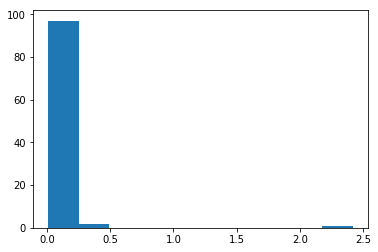

In [15]:
#run PCA on subset of the data to filter out overrepresented species and project reduced matrix down to species subspace

from sklearn.decomposition import TruncatedSVD as svd
import pickle
from matplotlib import pyplot as plt

handle1 =open('./BigCoEvMatrix.pkl' , 'r')
cooevolution_matrix = pickle.load(handle1)
handle1.close()



handle1 = open('./hogs.pkl','r')
handle2= open('./fams.pkl','r')
handle3 = open('./taxa.pkl','r')

Hogs = pickle.load(handle1)
Fams = pickle.load(handle2)
Taxa = pickle.load(handle3)

handle1.close()
handle2.close()
handle3.close()



#manifold is consistent across all hogs? Use random subsample for PCA








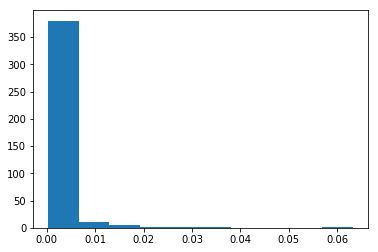

In [36]:
randHogs = np.random.randint(0,len(Hogs), 100000)
submatrix = cooevolution_matrix[randHogs,:]
SVD = svd(n_components=400)
SVD.fit(submatrix)
plt.hist(SVD.explained_variance_ratio_.T)

plt.show()




In [37]:
print np.sum(SVD.explained_variance_ratio_.T)

print 'variance w/' + str(SVD.n_components) + ' components'



0.810604480555
variance w/400 components


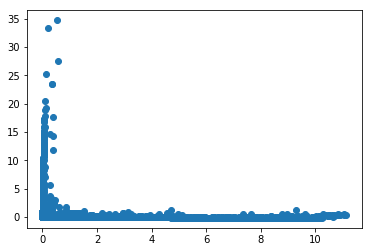

In [38]:
subT = SVD.transform(submatrix)
plt.scatter(subT[:,0],subT[:,1])
plt.show()